In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy
import astropy.units as u
import astropy.constants as ac
import sunpy.map
import sunpy.visualization.colormaps as cm
import skimage
import glob
from pathlib import Path

from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import silhouette_score, confusion_matrix, f1_score



import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers


import autoenc_model as aem
import data_generator as dg
import utils
import json

import ipywidgets as widgets

import datetime
from tqdm.notebook import tqdm


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
2023-06-25 22:25:40.781375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
latent_size = 1024
batch_size = 48
all_gen_input = dg.MultiChannelAEGenerator("data/composite_data/", batch_size, test_split=0, shuffle=False, noise_filter=True)
all_gen_input.take_all = True

25650
19012


In [3]:
weights = tf.constant([0.5,0.5,2])
def modified_mse(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(tf.reduce_mean(squared_difference, axis=(0,1,2)) * weights) # Note the `axis=-1`

autoencoder = keras.models.load_model("autoencoder_VAE_ft_1024_xception.h5", custom_objects={"modified_mse": modified_mse})
encoder = keras.models.load_model("encoder_VAE_ft_1024_xception.h5")
decoder = keras.models.load_model("decoder_VAE_ft_1024_xception.h5")

2023-06-25 22:25:42.351562: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


/home/eugeniolr/Documents/master/TFM/data_generator.py:194: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:195: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:203: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)


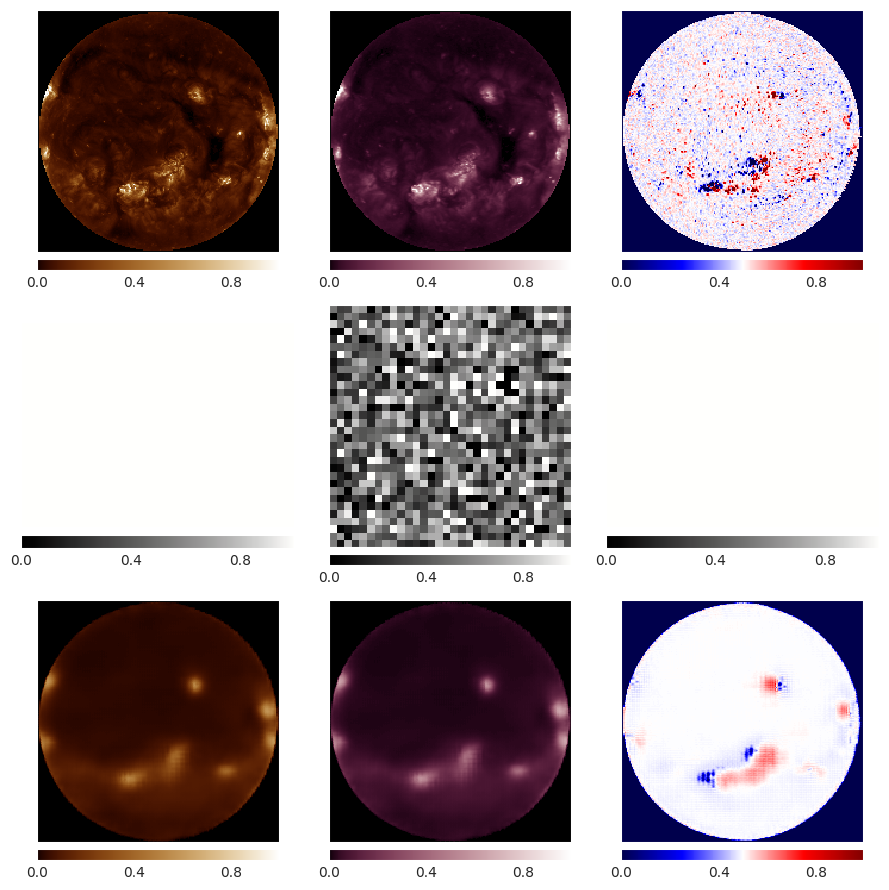

In [4]:
test_img = all_gen_input.sample(1)
#code = encoder(test_img)
mean, var, code = encoder(test_img)
decoded = decoder(code)

test_img_channels = [i for i in test_img[0].transpose(2,0,1)]


code = (utils.square_dims_vector(np.asarray(code[0])) + 1)/2
code_img = [np.ones((3,4)), code, np.ones((3,4))]
                     
decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]

isns.ImageGrid(
    test_img_channels+code_img+decoded_img_channels,
    cmap=["sdoaia193", "sdoaia211", "seismic"] + ["gray"]*3 + ["sdoaia193", "sdoaia211", "seismic"],
    orientation="h",
    vmin=0, 
    vmax=1
)

In [5]:
path = Path("encoded_images.npy")

if path.is_file():
    codes = np.load("encoded_images.npy")
else:
    latent_size = 1024
    codes = np.empty((len(all_gen_input.file_list), latent_size))
    for idx, val in tqdm(enumerate(all_gen_input), total=len(all_gen_input), desc="Encoding images"):
        codes[batch_size*idx:batch_size*(idx+1)] = encoder.predict(val[0], verbose=False)[2]

    np.save("encoded_images.npy", codes)

In [6]:
codes.shape

(19012, 1024)

In [7]:
solar_wind_class = pd.read_csv("./is_fast_solar_wind.csv", index_col=0)
solar_wind_class = solar_wind_class.sort_values(by="datetime")
solar_wind_class["is_fast_wind"] = solar_wind_class["is_fast_wind"] == 1
solar_wind_class

,datetime,is_fast_wind,CME
14371,2012-10-03 03:30:19,False,False
4008,2012-10-03 04:06:22,False,False
15240,2012-10-03 04:42:56,False,False
5180,2012-10-03 05:19:13,False,False
16610,2012-10-03 05:55:39,False,False
...,...,...,...
12491,2020-07-03 03:43:17,False,False
17829,2020-07-03 04:50:23,False,False
9694,2020-07-03 05:56:43,False,False
165,2020-07-03 07:03:03,False,False


In [8]:
print(f"Nº fast wind days: {np.count_nonzero(solar_wind_class['is_fast_wind']):6d} out ot {len(solar_wind_class)}")
print(f"Nº CME days:       {np.count_nonzero(solar_wind_class['CME']):6d} out ot {len(solar_wind_class)}")

Nº fast wind days:   1825 out ot 19012
Nº CME days:          754 out ot 19012


In [9]:
train_test_size = 0.3
codes_fw_train, codes_fw_test, target_fw_train, target_fw_test = train_test_split(codes, solar_wind_class["is_fast_wind"], test_size=train_test_size, shuffle=True, stratify=solar_wind_class["is_fast_wind"])
codes_cme_train, codes_cme_test, target_cme_train, target_cme_test = train_test_split(codes, solar_wind_class["CME"], test_size=train_test_size, shuffle=True, stratify=solar_wind_class["CME"])

In [10]:
print("Fast wind Train:")
print(f"\tNº of data points: {target_fw_train.size}")
print(f"\tFor class 0: {np.count_nonzero(target_fw_train == 0)}")
print(f"\tFor class 1: {np.count_nonzero(target_fw_train == 1)}")
print()
print("Fast wind Test:")
print(f"\tNº of data points: {target_fw_test.size}")
print(f"\tFor class 0: {np.count_nonzero(target_fw_test == 0)}")
print(f"\tFor class 1: {np.count_nonzero(target_fw_test == 1)}")

Fast wind Train:
	Nº of data points: 13308
	For class 0: 12031
	For class 1: 1277

Fast wind Test:
	Nº of data points: 5704
	For class 0: 5156
	For class 1: 548


In [11]:
print("CME Train:")
print(f"\tNº of data points: {target_cme_train.size}")
print(f"\tFor class 0: {np.count_nonzero(target_cme_train == 0)}")
print(f"\tFor class 1: {np.count_nonzero(target_cme_train == 1)}")
print()
print("CME Test:")
print(f"\tNº of data points: {target_cme_test.size}")
print(f"\tFor class 0: {np.count_nonzero(target_cme_test == 0)}")
print(f"\tFor class 1: {np.count_nonzero(target_cme_test == 1)}")

CME Train:
	Nº of data points: 13308
	For class 0: 12780
	For class 1: 528

CME Test:
	Nº of data points: 5704
	For class 0: 5478
	For class 1: 226


In [12]:
conf_mat_norm = "true"
# conf_mat_norm = None

# Baseline (Dummy classifier)

In [44]:
model_fw = DummyClassifier(strategy="uniform")

model_fw = model_fw.fit(codes_fw_train, target_fw_train)

pred_fw_train = model_fw.predict(codes_fw_train)
pred_fw_test = model_fw.predict(codes_fw_test)

print("Fast solar wind F1 score:")
print(f"Test: {f1_score(pred_fw_train, target_fw_train):4f}")
print(f"Train: {f1_score(pred_fw_test, target_fw_test):4f}")

Fast solar wind F1 score:
Test: 0.162841
Train: 0.164254


In [49]:
model_cme = DummyClassifier(strategy="uniform")

model_cme = model_cme.fit(codes_cme_train, target_cme_train)

pred_cme_train = model_cme.predict(codes_cme_train)
pred_cme_test = model_cme.predict(codes_cme_test)

print("CME F1 score:")
print(f"Test: {f1_score(pred_cme_train, target_cme_train):4f}")
print(f"Train: {f1_score(pred_cme_test, target_cme_test):4f}")

CME F1 score:
Test: 0.076497
Train: 0.068144


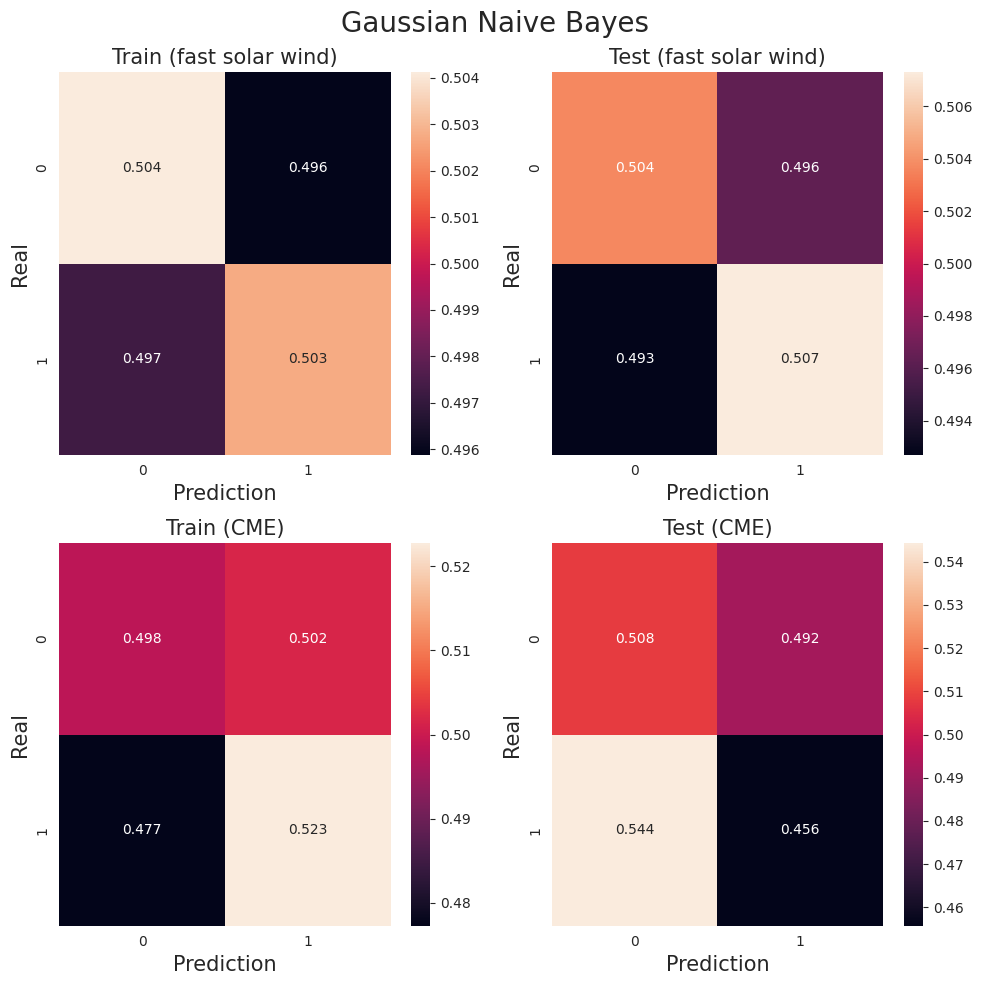

In [50]:
train_fw_confmat = confusion_matrix(target_fw_train, pred_fw_train, normalize=conf_mat_norm)
test_fw_confmat = confusion_matrix(target_fw_test, pred_fw_test, normalize=conf_mat_norm)
train_cme_confmat = confusion_matrix(target_cme_train, pred_cme_train, normalize=conf_mat_norm)
test_cme_confmat = confusion_matrix(target_cme_test, pred_cme_test, normalize=conf_mat_norm)

fig, ax = plt.subplots(2,2,figsize=(10,10))

fig.suptitle("Gaussian Naive Bayes", fontsize=20)

heatmap_ax = sns.heatmap(train_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (fast solar wind)")

heatmap_ax = sns.heatmap(test_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (fast solar wind)")

heatmap_ax = sns.heatmap(train_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (CME)")

heatmap_ax = sns.heatmap(test_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (CME)")

plt.tight_layout()
plt.show()

# Naive Bayes

In [16]:
model_fw = GaussianNB(var_smoothing=5e-4)

model_fw = model_fw.fit(codes_fw_train, target_fw_train)

pred_fw_train = model_fw.predict(codes_fw_train)
pred_fw_test = model_fw.predict(codes_fw_test)

print("Fast solar wind F1 score:")
print(f"Test: {f1_score(pred_fw_train, target_fw_train):4f}")
print(f"Train: {f1_score(pred_fw_test, target_fw_test):4f}")

Fast solar wind F1 score:
Test: 0.236752
Train: 0.215531


In [17]:
model_cme = GaussianNB(var_smoothing=5e-4)

model_cme = model_cme.fit(codes_cme_train, target_cme_train)

pred_cme_train = model_cme.predict(codes_cme_train)
pred_cme_test = model_cme.predict(codes_cme_test)

print("CME F1 score:")
print(f"Test: {f1_score(pred_cme_train, target_cme_train):4f}")
print(f"Train: {f1_score(pred_cme_test, target_cme_test):4f}")

CME F1 score:
Test: 0.155291
Train: 0.139963


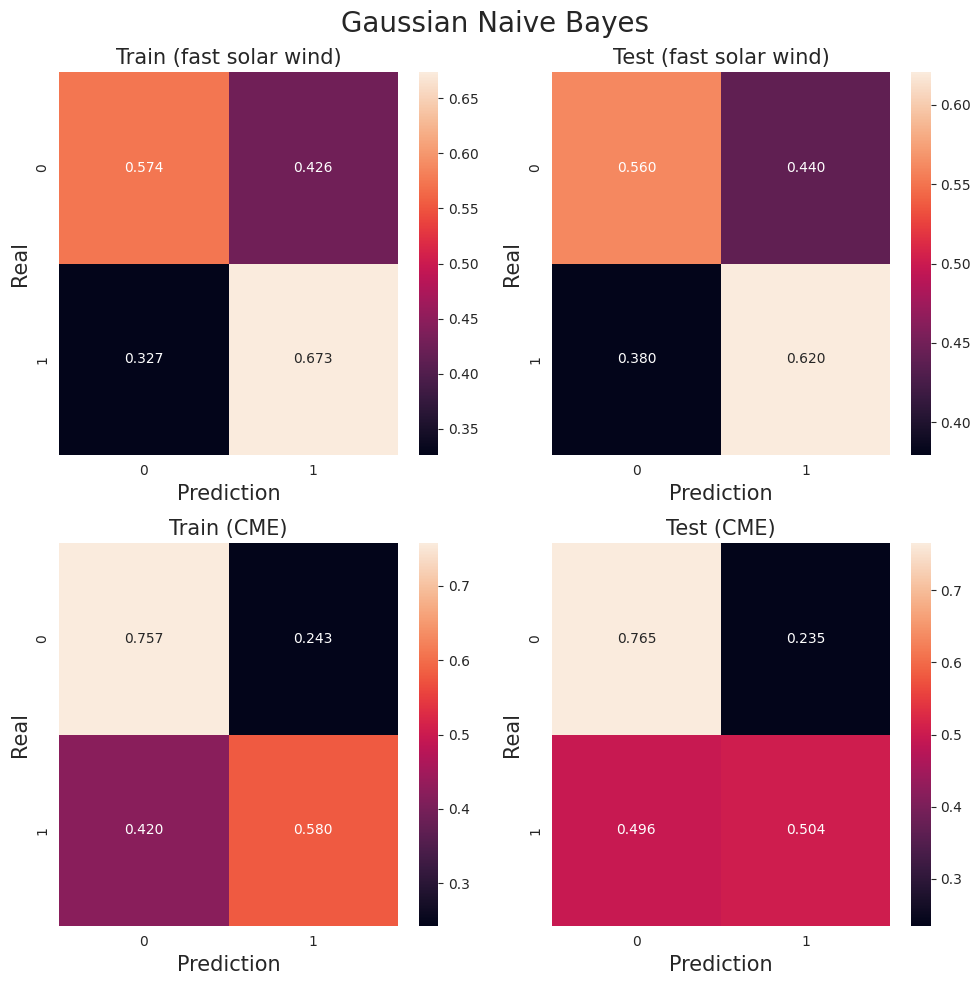

In [18]:
train_fw_confmat = confusion_matrix(target_fw_train, pred_fw_train, normalize=conf_mat_norm)
test_fw_confmat = confusion_matrix(target_fw_test, pred_fw_test, normalize=conf_mat_norm)
train_cme_confmat = confusion_matrix(target_cme_train, pred_cme_train, normalize=conf_mat_norm)
test_cme_confmat = confusion_matrix(target_cme_test, pred_cme_test, normalize=conf_mat_norm)

fig, ax = plt.subplots(2,2,figsize=(10,10))

fig.suptitle("Gaussian Naive Bayes", fontsize=20)

heatmap_ax = sns.heatmap(train_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (fast solar wind)")

heatmap_ax = sns.heatmap(test_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (fast solar wind)")

heatmap_ax = sns.heatmap(train_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (CME)")

heatmap_ax = sns.heatmap(test_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (CME)")

plt.tight_layout()
plt.show()

# Gaussian Mixture

In [19]:
model_fw = GaussianMixture(n_components=2)

model_fw = model_fw.fit(codes_fw_train)

pred_fw_train = model_fw.predict(codes_fw_train)
pred_fw_test = model_fw.predict(codes_fw_test)

print("Fast solar wind F1 score:")
print(f"Test: {f1_score(pred_fw_train, target_fw_train):4f}")
print(f"Train: {f1_score(pred_fw_test, target_fw_test):4f}")

Fast solar wind F1 score:
Test: 0.147984
Train: 0.172154


In [20]:
model_cme = GaussianMixture(n_components=2)

model_cme = model_cme.fit(codes_cme_train)

pred_cme_train = model_cme.predict(codes_cme_train)
pred_cme_test = model_cme.predict(codes_cme_test)

print("CME F1 score:")
print(f"Test: {f1_score(pred_cme_train, target_cme_train):4f}")
print(f"Train: {f1_score(pred_cme_test, target_cme_test):4f}")

CME F1 score:
Test: 0.072534
Train: 0.079038


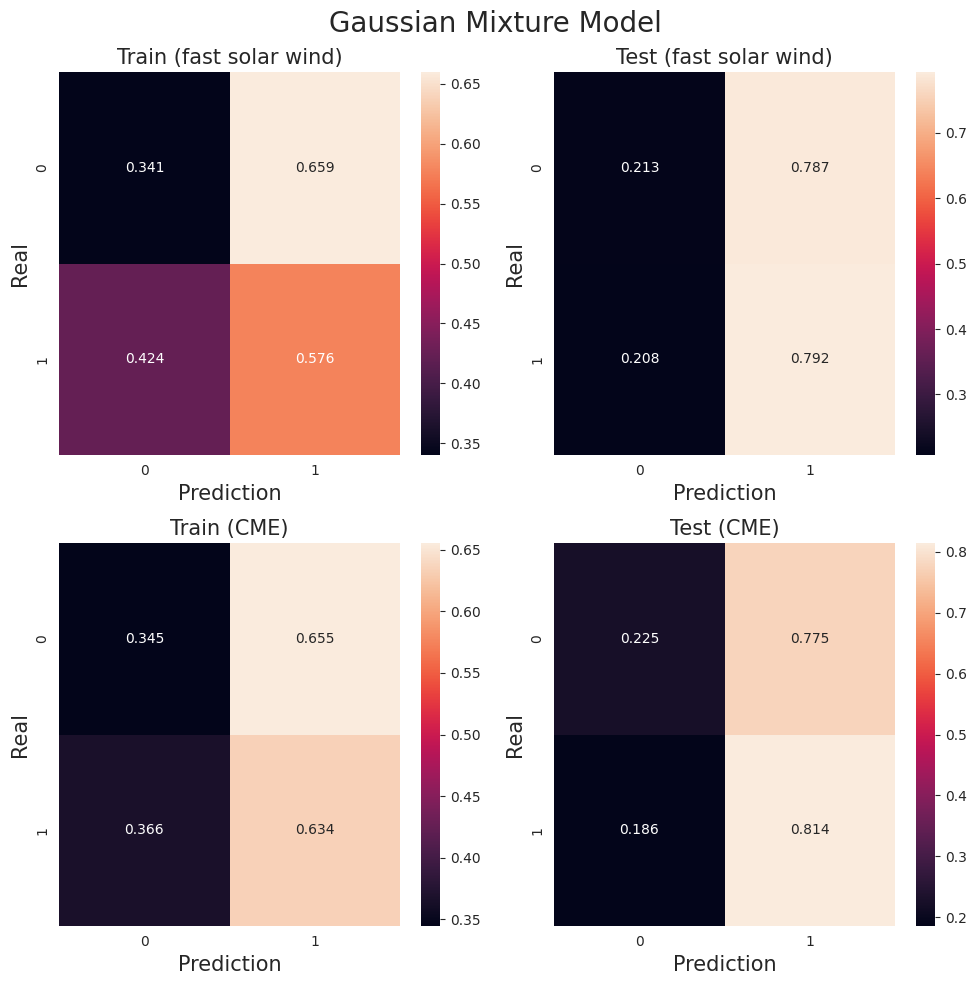

In [21]:
train_fw_confmat = confusion_matrix(target_fw_train, pred_fw_train, normalize=conf_mat_norm)
test_fw_confmat = confusion_matrix(target_fw_test, pred_fw_test, normalize=conf_mat_norm)
train_cme_confmat = confusion_matrix(target_cme_train, pred_cme_train, normalize=conf_mat_norm)
test_cme_confmat = confusion_matrix(target_cme_test, pred_cme_test, normalize=conf_mat_norm)

fig, ax = plt.subplots(2,2,figsize=(10,10))

fig.suptitle("Gaussian Mixture Model", fontsize=20)

heatmap_ax = sns.heatmap(train_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (fast solar wind)")

heatmap_ax = sns.heatmap(test_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (fast solar wind)")

heatmap_ax = sns.heatmap(train_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (CME)")

heatmap_ax = sns.heatmap(test_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (CME)")

plt.tight_layout()
plt.show()

# Logistic Regression

In [22]:
model_fw = LogisticRegression(penalty="l2", solver="newton-cg", max_iter=300, C=1)

model_fw = model_fw.fit(codes_fw_train, target_fw_train)

pred_fw_train = model_fw.predict(codes_fw_train)
pred_fw_test = model_fw.predict(codes_fw_test)

print("Fast solar wind F1 score:")
print(f"Test: {f1_score(pred_fw_train, target_fw_train):4f}")
print(f"Train: {f1_score(pred_fw_test, target_fw_test):4f}")

Fast solar wind F1 score:
Test: 0.362353
Train: 0.196382


In [23]:
model_cme = LogisticRegression(penalty="l2", solver="newton-cg", max_iter=300, C=1)

model_cme = model_cme.fit(codes_cme_train, target_cme_train)

pred_cme_train = model_cme.predict(codes_cme_train)
pred_cme_test = model_cme.predict(codes_cme_test)

print("CME F1 score:")
print(f"Test: {f1_score(pred_cme_train, target_cme_train):4f}")
print(f"Train: {f1_score(pred_cme_test, target_cme_test):4f}")

CME F1 score:
Test: 0.351714
Train: 0.087838


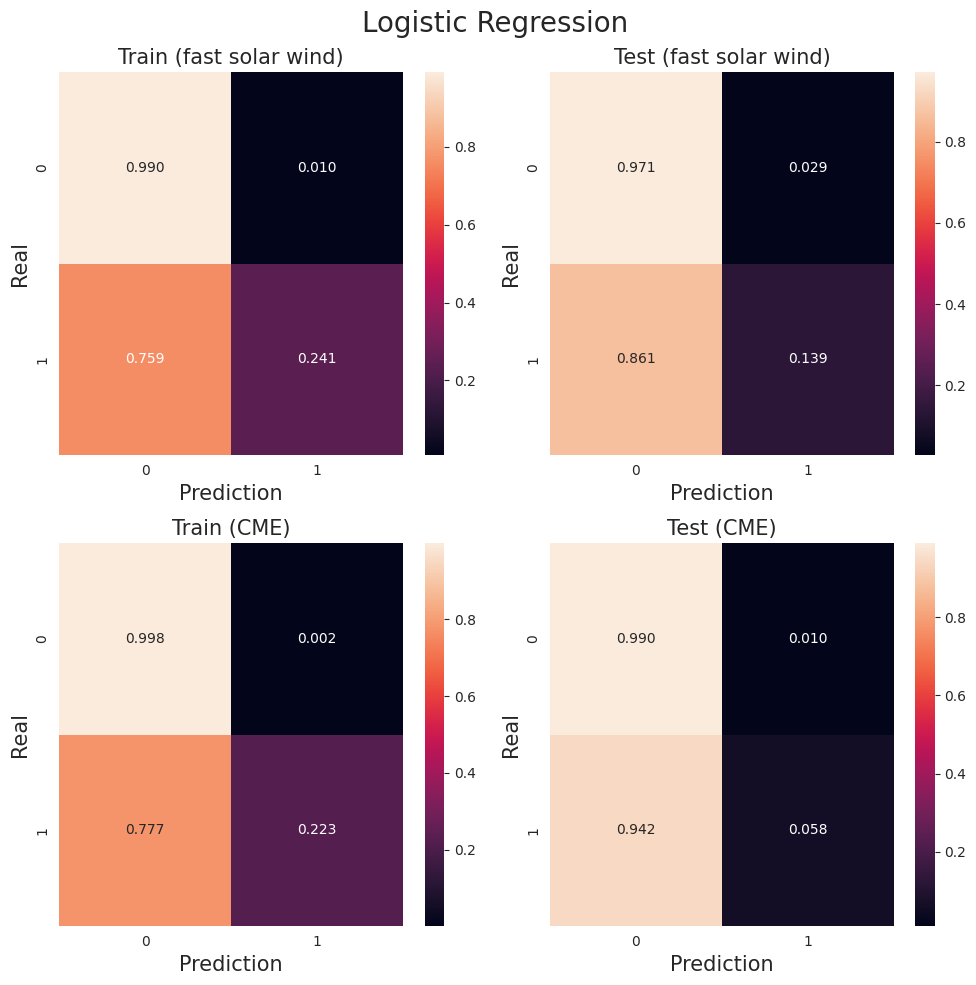

In [24]:
train_fw_confmat = confusion_matrix(target_fw_train, pred_fw_train, normalize=conf_mat_norm)
test_fw_confmat = confusion_matrix(target_fw_test, pred_fw_test, normalize=conf_mat_norm)
train_cme_confmat = confusion_matrix(target_cme_train, pred_cme_train, normalize=conf_mat_norm)
test_cme_confmat = confusion_matrix(target_cme_test, pred_cme_test, normalize=conf_mat_norm)

fig, ax = plt.subplots(2,2,figsize=(10,10))

fig.suptitle("Logistic Regression", fontsize=20)

heatmap_ax = sns.heatmap(train_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (fast solar wind)")

heatmap_ax = sns.heatmap(test_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (fast solar wind)")

heatmap_ax = sns.heatmap(train_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (CME)")

heatmap_ax = sns.heatmap(test_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (CME)")

plt.tight_layout()
plt.show()

# K-nearest neighbours 

In [36]:
model_fw = KNeighborsClassifier(n_neighbors=1)

model_fw = model_fw.fit(codes_fw_train, target_fw_train)

pred_fw_train = model_fw.predict(codes_fw_train)
pred_fw_test = model_fw.predict(codes_fw_test)

print("Fast solar wind F1 score:")
print(f"Test: {f1_score(pred_fw_train, target_fw_train):4f}")
print(f"Train: {f1_score(pred_fw_test, target_fw_test):4f}")

Fast solar wind F1 score:
Test: 1.000000
Train: 0.893773


In [26]:
model_cme = KNeighborsClassifier(n_neighbors=1)

model_cme = model_cme.fit(codes_cme_train, target_cme_train)

pred_cme_train = model_cme.predict(codes_cme_train)
pred_cme_test = model_cme.predict(codes_cme_test)

print("CME F1 score:")
print(f"Test: {f1_score(pred_cme_train, target_cme_train):4f}")
print(f"Train: {f1_score(pred_cme_test, target_cme_test):4f}")

CME F1 score:
Test: 1.000000
Train: 0.895928


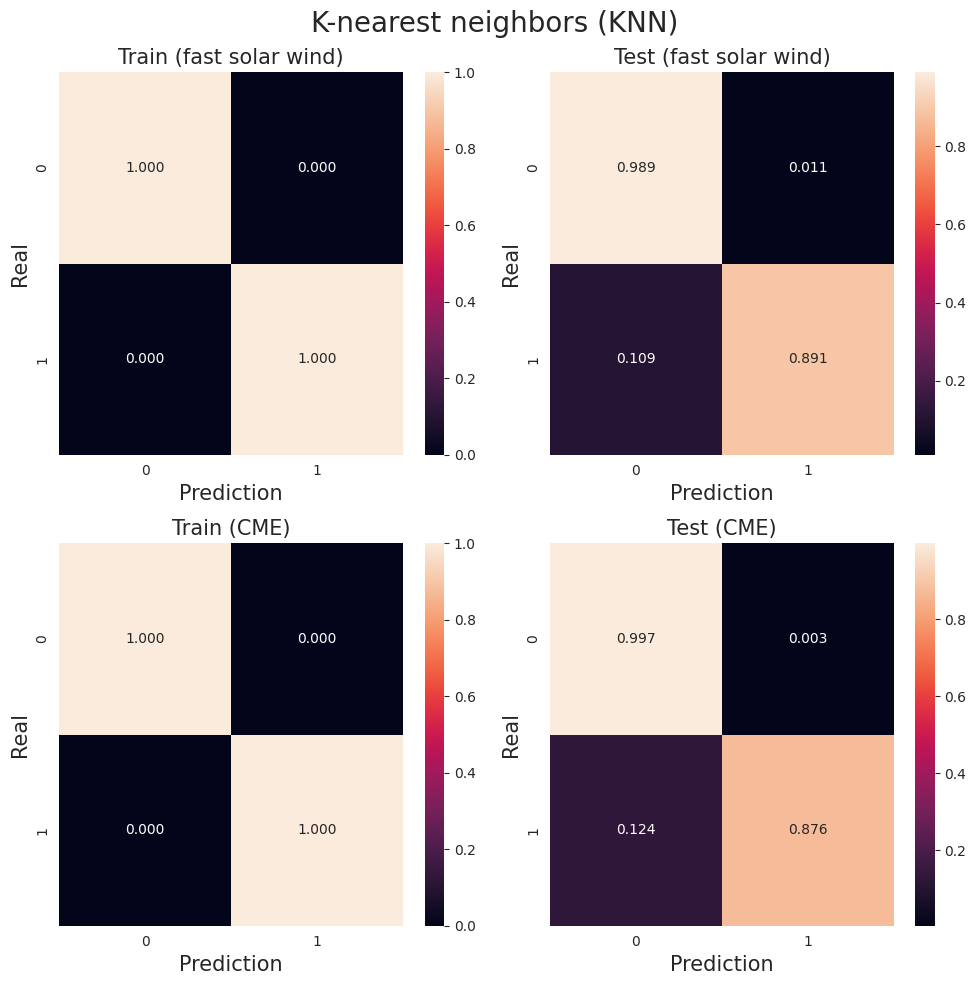

In [27]:
train_fw_confmat = confusion_matrix(target_fw_train, pred_fw_train, normalize=conf_mat_norm)
test_fw_confmat = confusion_matrix(target_fw_test, pred_fw_test, normalize=conf_mat_norm)
train_cme_confmat = confusion_matrix(target_cme_train, pred_cme_train, normalize=conf_mat_norm)
test_cme_confmat = confusion_matrix(target_cme_test, pred_cme_test, normalize=conf_mat_norm)

fig, ax = plt.subplots(2,2,figsize=(10,10))

fig.suptitle("K-nearest neighbors (KNN)", fontsize=20)

heatmap_ax = sns.heatmap(train_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (fast solar wind)")

heatmap_ax = sns.heatmap(test_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (fast solar wind)")

heatmap_ax = sns.heatmap(train_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (CME)")

heatmap_ax = sns.heatmap(test_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (CME)")

plt.tight_layout()
plt.show()

# Decision Tree

In [28]:
model_fw = DecisionTreeClassifier(max_depth=None, criterion="entropy")

model_fw = model_fw.fit(codes_fw_train, target_fw_train)

pred_fw_train = model_fw.predict(codes_fw_train)
pred_fw_test = model_fw.predict(codes_fw_test)

print("Fast solar wind F1 score:")
print(f"Test: {f1_score(pred_fw_train, target_fw_train):4f}")
print(f"Train: {f1_score(pred_fw_test, target_fw_test):4f}")

Fast solar wind F1 score:
Test: 1.000000
Train: 0.469424


In [29]:
model_cme = DecisionTreeClassifier(max_depth=15, criterion="log_loss")

model_cme = model_cme.fit(codes_cme_train, target_cme_train)

pred_cme_train = model_cme.predict(codes_cme_train)
pred_cme_test = model_cme.predict(codes_cme_test)

print("CME F1 score:")
print(f"Test: {f1_score(pred_cme_train, target_cme_train):4f}")
print(f"Train: {f1_score(pred_cme_test, target_cme_test):4f}")

CME F1 score:
Test: 0.973535
Train: 0.296128


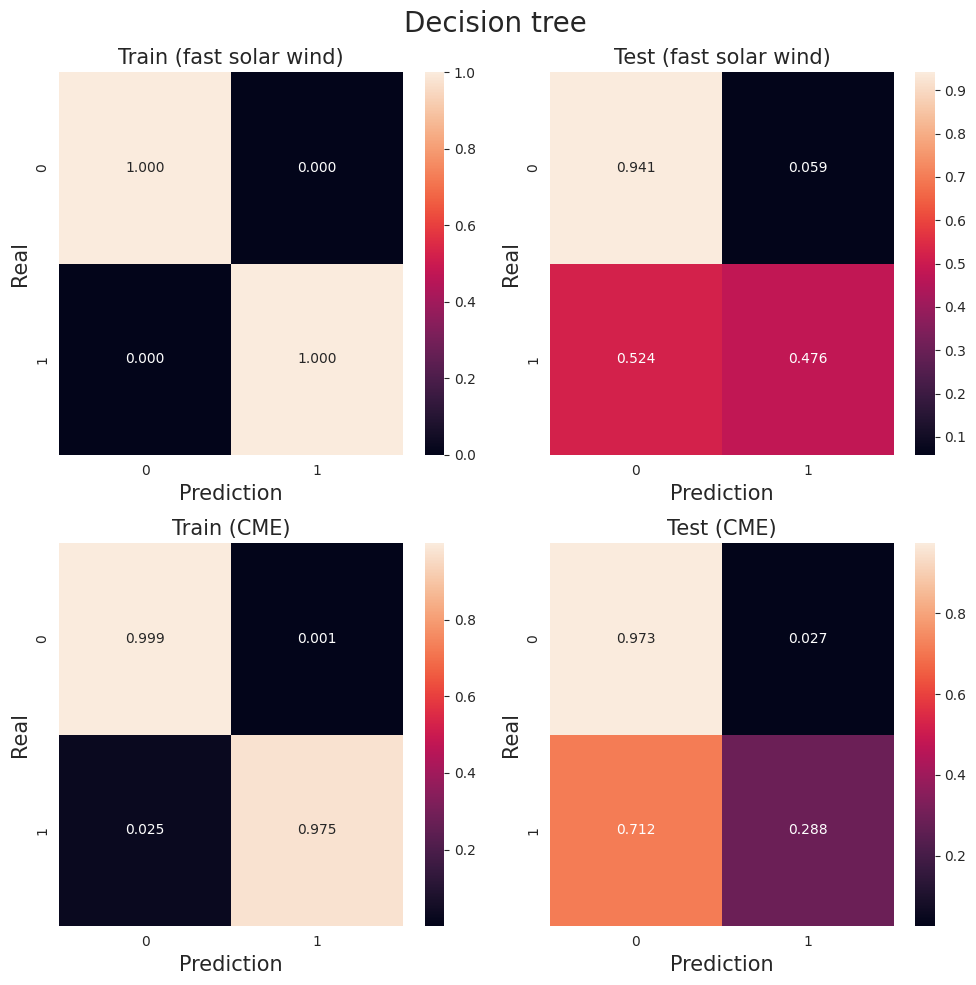

In [30]:
train_fw_confmat = confusion_matrix(target_fw_train, pred_fw_train, normalize=conf_mat_norm)
test_fw_confmat = confusion_matrix(target_fw_test, pred_fw_test, normalize=conf_mat_norm)
train_cme_confmat = confusion_matrix(target_cme_train, pred_cme_train, normalize=conf_mat_norm)
test_cme_confmat = confusion_matrix(target_cme_test, pred_cme_test, normalize=conf_mat_norm)

fig, ax = plt.subplots(2,2,figsize=(10,10))

fig.suptitle("Decision tree", fontsize=20)

heatmap_ax = sns.heatmap(train_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (fast solar wind)")

heatmap_ax = sns.heatmap(test_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (fast solar wind)")

heatmap_ax = sns.heatmap(train_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (CME)")

heatmap_ax = sns.heatmap(test_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (CME)")

plt.tight_layout()
plt.show()

# Random forest

In [31]:
model_fw = RandomForestClassifier(n_estimators=100, max_depth=25, n_jobs=-1)

model_fw = model_fw.fit(codes_fw_train, target_fw_train)

pred_fw_train = model_fw.predict(codes_fw_train)
pred_fw_test = model_fw.predict(codes_fw_test)

print("Fast solar wind F1 score:")
print(f"Test: {f1_score(pred_fw_train, target_fw_train):4f}")
print(f"Train: {f1_score(pred_fw_test, target_fw_test):4f}")

Fast solar wind F1 score:
Test: 0.999216
Train: 0.116438


In [32]:
model_cme = RandomForestClassifier(n_estimators=150, max_depth=20, n_jobs=-1)

model_cme = model_cme.fit(codes_cme_train, target_cme_train)

pred_cme_train = model_cme.predict(codes_cme_train)
pred_cme_test = model_cme.predict(codes_cme_test)

print("CME F1 score:")
print(f"Test: {f1_score(pred_cme_train, target_cme_train):4f}")
print(f"Train: {f1_score(pred_cme_test, target_cme_test):4f}")

CME F1 score:
Test: 0.903427
Train: 0.060086


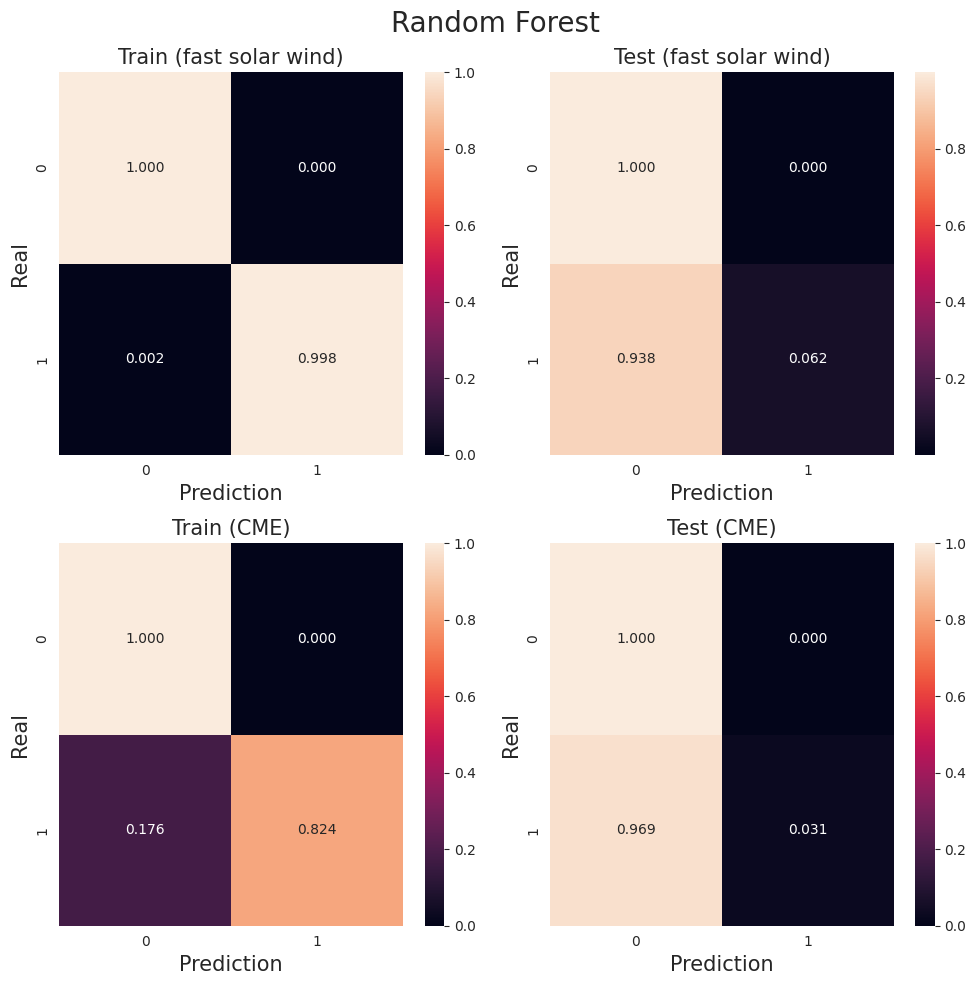

In [33]:
train_fw_confmat = confusion_matrix(target_fw_train, pred_fw_train, normalize=conf_mat_norm)
test_fw_confmat = confusion_matrix(target_fw_test, pred_fw_test, normalize=conf_mat_norm)
train_cme_confmat = confusion_matrix(target_cme_train, pred_cme_train, normalize=conf_mat_norm)
test_cme_confmat = confusion_matrix(target_cme_test, pred_cme_test, normalize=conf_mat_norm)

fig, ax = plt.subplots(2,2,figsize=(10,10))

fig.suptitle("Random Forest", fontsize=20)

heatmap_ax = sns.heatmap(train_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (fast solar wind)")

heatmap_ax = sns.heatmap(test_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (fast solar wind)")

heatmap_ax = sns.heatmap(train_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (CME)")

heatmap_ax = sns.heatmap(test_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (CME)")

plt.tight_layout()
plt.show()